In [1]:
import numpy as np
import polytope as pc
from itertools import combinations

import matplotlib.pyplot as plt

import sys
sys.path.append('../')

from best.abstraction import LTIAbstraction
from best.mdp import *
from best.policy import *

from Models.Linear import LTI

# Define the linear time invariant system
#A = np.array([[0,-0.8572],[0.1,0.5]])
dim = 2
A = np.eye(2) #np.array([[.9,-0.32],[0.1,0.9]])
B = np.eye(dim)  #array([[1], [0.1]])
W = np.array([[0,0],[0,0.4]]) #2*Tr.dot(np.eye(dim)).dot(Tr)  # noise on transitions
 
# Accuracy
C = np.array([[1, 0],[0,1]])  # defines metric for error (||y_finite-y||< epsilon with y= cx   )

sys_lti = LTI(A, B, C, None, W=W)  # LTI system with   D = None
sys_lti.setU(pc.box2poly(np.kron(np.ones((sys_lti.m, 1)), np.array([[-1, 1]])))) # continuous set of inputs
sys_lti.setX(pc.box2poly(np.kron(np.ones((sys_lti.dim, 1)), np.array([[-10, 10]])))) # X space

sys_n = sys_lti.normalize()

In [2]:
# Define regions of interest for the labeling
regions = dict()
regions['target1'] = pc.box2poly(np.array([[-9, -6], [6, 9]]))
# add avoid
regions['target2'] = pc.box2poly(np.array([[6, 9], [6, 9]]))

In [3]:
## step 1: tune gridding ratio (find optimal horizontal d_1, and vertical d_2)
# currently only available for 2D
# d_opt, d_vals, eps_values = tune_dratio(sys_n)

d_opt = np.array([[ 0.69294],
                  [ 0.721  ]])

# d = np.array([[1.5], [1.5]])
d = d_opt

### Construct map MDP

In [4]:
p1 = 0.5
p2 = 0.6

T0 = np.eye(3)
T1 = np.array([[0,p1,1-p1], [0,1,0], [0,0,1]])
T2 = np.array([[0,p2,1-p2], [0,1,0], [0,0,1]])

def output_fcn(n):
    if n == 0:
        return 'init'    # label unknown
    if n == 1:
        return 'sample'  # there is a sample
    if n == 2:
        return 'empty'   # no sample
    
map1 = MDP([T0, T1], input_name='meas1',
                     output_fcn=output_fcn, output_name='samplelabel1')

map2 = MDP([T0, T2], input_name='meas2',
                     output_fcn=output_fcn, output_name='samplelabel2')

map_mdp = ParallelMDP([map1, map2])
print map_mdp

MDP: 4 inputs "(meas1, meas2)" --> 9 states "(samplelabel1, samplelabel2)"


### Construct abstraction

Warning no inputspace given
Warning no state space given
status: optimal
optimal epsilon 1.00000639831
optimal M [[ 1.  0.]
 [ 0.  1.]]
Optimal K [[ 0. -1.]
 [-1.  0.]]
('check norm of rows', matrix([[ 0.,  1.],
        [-1.,  0.],
        [ 0., -1.],
        [ 1.,  0.]]))
('check norm of rows', matrix([[ 0.,  1.],
        [-1.,  0.],
        [ 0., -1.],
        [ 1.,  0.]]))
MDP: 16 inputs "u_d" --> 871 states "(s, x_d)"


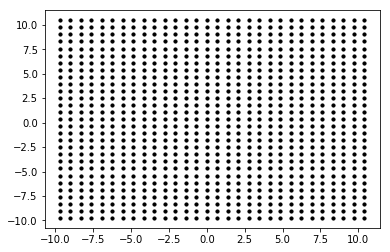

In [5]:
# mdp_grid = sys_n.abstract_io(d, un=4, verbose=False)  # do the gridding
# mdp_grid.map_dfa_inputs(dict_input2prop, regions)

abstr = LTIAbstraction(sys_n, d, un=4)
abstr.set_regions(regions)

in_regions, nin_regions = abstr.map_dfa_inputs()

fig = plt.figure()
abstr.plot(fig)
print abstr.mdp

### Connect abstraction and map

In [6]:
# mapping (s, x_d) -> (meas1, meas2)
def map_connection(s_xd):
    x_d = np.array(s_xd[1]).reshape((2,1))
        
    ret = [0 for i in range(len(regions))]
    for i, poly in enumerate(regions.itervalues()):
        if poly.contains(x_d):
            ret[i] = 1
    return set([tuple(ret)])

print map_connection((0, np.array([[3],[3]])) )
print map_connection((0, np.array([[8.5],[8.5]])) )
print map_connection((0, np.array([[-8.5],[8.5]])) )

prod_mdp = ProductMDP(abstr.mdp, map_mdp, map_connection)

print prod_mdp

set([(0, 0)])
set([(1, 0)])
set([(0, 1)])
MDP: 16 inputs "u_d" --> 7839 states "((s, x_d), (samplelabel1, samplelabel2))"


### Set up LTL problem

In [7]:
print np.nonzero(nin_regions['target1']==0)
print np.nonzero(nin_regions['target2']==0)

(array([728]), array([0]))
(array([749]), array([0]))


In [8]:
formula = '( F sample )'

def subsets(collection):
    for i in range(len(collection)+1):
        it = combinations(collection, i)
        try:
            while True:
                yield(list(next(it)))
        except StopIteration:
            pass
    raise StopIteration

def get_regions(s):
    '''compute subsets of possible regions corresponding to abstract state'''   
    if s == abstr.mdp.N-1:
        return set([ (), ])
    
    know_in = []
    know_out = []
    for reg in regions.keys():
        if in_regions[reg][s] == 0:
            know_out.append(reg)
        if nin_regions[reg][s] == 0:
            know_in.append(reg)
    uncertain = list(set(regions.keys()) - set(know_in) - set(know_out))
    return set([ tuple(know_in + unc) for unc in subsets(uncertain)])  

# map ((s, xd), (sample1, sample2)) -> 2^{sample}
def abstract_connection(s_xd_sample):
    s = s_xd_sample[0][0]
    regions = get_regions(s)
    
    sample1 = s_xd_sample[1][0]
    sample2 = s_xd_sample[1][1]

    if all('target1' in reg for reg in regions) and sample1 == 'sample' or \
       all('target2' in reg for reg in regions) and sample2 == 'sample':
        return set([tuple(['sample'])])
    else:
        return set([(), ])

print abstract_connection( ( (728, (_, _)), ('sample', 'empty') ) )
print abstract_connection( ( (728, (_, _)), ('empty', 'empty') ) )

print abstract_connection( ( (749, (_, _)), ('empty', 'sample') ) )
print abstract_connection( ( (749, (_, _)), ('empty', 'empty') ) )

set([('sample',)])
set([()])
set([('sample',)])
set([()])


### Solve with Petter's recursion

In [9]:
import best.policy as bp
from best.ltl import formula_to_mdp

reload(bp)

dfsa, init, final, _ = formula_to_mdp(formula)
mdp_dfsa = ProductMDP(prod_mdp, dfsa, abstract_connection)
print mdp_dfsa

V, pol = mdp_dfsa.solve_reach(accept=lambda s: s[1] in final)

pol_qn = pol.reshape( (dfsa.N, prod_mdp.N), order='F' )
V_qn = V.reshape( (dfsa.N, prod_mdp.N), order='F' )

pol_pn = bp.LTL_Policy(dfsa, list(init)[0], final, pol_qn, V_qn)

MDP: 16 inputs "u_d" --> 15678 states "(((s, x_d), (samplelabel1, samplelabel2)), mu)"
iteration 0, time 2.86102294922e-06
iteration 1, time 641.228650808
iteration 2, time 641.263207912
iteration 3, time 641.28863883
iteration 4, time 641.312835932
iteration 5, time 641.335270882
iteration 6, time 641.374309778
iteration 7, time 641.401251793
iteration 8, time 641.425042868
iteration 9, time 641.456479788
iteration 10, time 641.495358944
iteration 11, time 641.517067909
iteration 12, time 641.537657976
iteration 13, time 641.55973196
iteration 14, time 641.581784964
iteration 15, time 641.604384899
iteration 16, time 641.628880978
iteration 17, time 641.651887894
iteration 18, time 641.677990913
iteration 19, time 641.702953815
iteration 20, time 641.727600813
iteration 21, time 641.750677824
iteration 22, time 641.77402401
iteration 23, time 641.797737837
iteration 24, time 641.8211689
iteration 25, time 641.844470978
iteration 26, time 641.866645813
iteration 27, time 641.892235994


### Solve with Sofie's recursion

In [10]:
from best.bellman import reach_dfa

dfsa, dfsa_init, dfsa_final, _ = formula_to_mdp(formula)

act_inputs = np.array([[1 if q in map(dfsa.input, abstract_connection( prod_mdp.output(s) )) else 0 
                        for s in range(prod_mdp.N)] for q in range(dfsa.N)])
act_inputs[:,-1] = 0

V, pol_mat, W = reach_dfa(act_inputs, prod_mdp, dfsa, dfsa_final, V=None, recursions=30)
pol_sof = LTL_Policy(dfsa, list(dfsa_init)[0], dfsa_final, pol_mat, V)

### Define policy and plot

In [43]:
pol = pol_sof

# define a policy on top of mdp policy
def my_policy(x, sam1, sam2):
    # x: current concrete state [x; y]
    # sam1: current state of target1 {0,1,2}
    # sam2: current state of target2 {0,1,2}
    x = np.array(x).reshape((2,1))
    x_transformed = abstr.transform(x)
    
    if regions['target1'].contains(x_transformed) and sam1 == 1 or \
       regions['target2'].contains(x_transformed) and sam2 == 1:
        aps = set(['sample'])
    else:
        aps = set([])
    pol.report_aps(aps)
    
    s_abstract = abstr.closest_abstract(x_transformed)
    
    s_tot = prod_mdp.global_state((s_abstract, (sam1, sam2) ))
    
    u_abstract, curr_val = pol.get_input(s_abstract)
    print u_abstract

    return abstr.refine_input(u_abstract, s_abstract, x_transformed)

def my_value(x):    
    x = np.array(x).reshape((2,1))
    x_transformed = abstr.transform(x)
    
    s_abstract = abstr.closest_abstract(x_transformed)
    
    s_tot = prod_mdp.global_state( (s_abstract, (0, 0)) )

    return V_qn[0, s_tot]

def my_policy_init(x, sam1, sam2):
    u = my_policy(x, 0, 0)
    pol_pn.reset()
    return u

6. Plot concrete systen
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
3.0
0.0
0.0
0.0
3.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
3.0
0.0
0.0
0.0
3.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
3.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
3.0
0.0
0.0
0.0
3.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
3.0
0.0
0.0
0.0
3.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
3.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
3.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
3.0
0.0
0.0
0.0
3.0
0.0
0.0
0.0


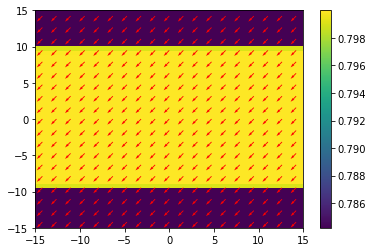

In [44]:
print('6. Plot concrete systen')
fig = plt.figure()
x_edge = np.linspace(-15,15,50)
x_del = np.diff(x_edge).max()
y_edge = np.linspace(-15,15,50)
y_del = np.diff(y_edge).max()

xi, yi = np.meshgrid(x_edge[:-1]+x_del/2,y_edge[:-1]+y_del/2)

values = np.array([[my_value((x,y)) for (x,y) in zip(xrow, yrow)] for (xrow,yrow) in zip(xi, yi)])

plt.pcolor(x_edge, y_edge, values.reshape(xi.shape))
plt.colorbar()
plt.xlim(np.array([-15,15]))
plt.ylim(np.array([-15,15]))

x_edge = np.linspace(-15,15,20)
x_del = np.diff(x_edge).max()
y_edge = np.linspace(-15,15,20)
y_del = np.diff(y_edge).max()

xi, yi = np.meshgrid(x_edge[:-1]+x_del/2,y_edge[:-1]+y_del/2)

u = np.array([[sys_lti.b.dot(my_policy_init((x,y), 0, 0 )) for (x,y) in zip(xrow, yrow)] for (xrow,yrow) in zip(xi, yi)])

delx = np.vstack([np.hstack([-np.array([[x], [y]]) + sys_lti.a.dot(np.array([[x], [y]])) + sys_lti.b.dot(my_policy_init((x,y), 0, 0 ))
         for (x,y) in zip(xrow, yrow)])
        for (xrow,yrow) in zip(xi, yi)])

x_tr = (np.block([[xi.flatten()], [yi.flatten()]]))

#plt.quiver(xi.flatten(), yi.flatten(),u[0],u[1])
plt.quiver(x_tr[0],x_tr[1],delx[0],delx[1], color = 'r')
print u

In [ ]:
# how to get a nice simulation? 
from random import  gauss 
import random
import scipy.linalg as scla
import matplotlib

random.seed(a = '4')
print('final state:', dfsa_final)
time = 50
fig = plt.figure()
ax = fig.add_subplot(111)
print(sys_lti.W)
Wsqrt = scla.sqrtm(sys_lti.W)
for x0 in (np.array([[-10],[-10]]),np.array([[10],[-5]])):
    for repeating in range(3):
        rpol.reset()
        
        x = np.zeros((2,time+1))
        x[:,[0]] = x0

        for t in range(time): 
            x[:,[t+1]] = (sys_lti.a.dot(x[:,[t]])+sys_lti.b.dot(rpol(x[:,[t]], transformed=False )) 
                        + np.array(Wsqrt).dot(np.array([[gauss(0,1)],[gauss(0,1)]])))
            if rpol.finished() :
                print('reached')
                break
        if not rpol.finished():
            print('not reached')
        plt.plot(x[0,0:t+1],x[1,0:t+1])
        plt.scatter(x[0],x[1], label='Finite states', color='k', s=10, marker="o")

plt.xlabel('x_1') 
plt.ylabel('x_2') 

plt.xlim(np.array([-15,15]))
plt.ylim(np.array([-15,15]))
# Define regions of interest for the labeling
regions = dict()
regions['target'] = pc.box2poly(np.kron(np.ones((2, 1)), np.array([[5, 10]])))
# add avoid
regions['avoid'] = pc.box2poly(np.array([[-5, 3],[-10, 5]]))

x = pc.extreme(regions['target'])
y = pc.extreme(regions['avoid'])

patch = matplotlib.patches.Polygon(x)
ax.add_patch(patch)

patch = matplotlib.patches.Polygon(y)
ax.add_patch(patch)